In this notebook we try to use the flow network for simulations

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2023-02-12 17:27:20.856383: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-02-12 17:27:20.856416: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
sys.path.insert(0,'../')
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import listdir_fullpath

In [ ]:
tfd = tfp.distributions
tfb = tfp.bijectors

## Load trained models

In [ ]:
from maddeb.utils import get_data_dir_path

data_dir = get_data_dir_path()

tf.get_logger().setLevel('ERROR')
latent_dim = 16
flow_net = FlowVAEnet(latent_dim=latent_dim)
flow_net.load_flow_weights(weights_path=os.path.join(data_dir, f"catsim_nonuni_shifted_lk_ssim_20{latent_dim}d/flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(data_dir, f"catsim_nonuni_shifted_lk_ssim_20{latent_dim}d/vae/val_loss"))
print(flow_net.vae_model.summary())

2023-02-12 17:27:41.062784: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-02-12 17:27:41.062898: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 17:27:41.062964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-02-12 17:27:41.063551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 17

0.001


2023-02-12 17:27:44.384253: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 152)               7030296   
_________________________________________________________________
latent_space (MultivariateNo ((None, 16), (None, 16))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         4966790   
Total params: 11,997,086
Trainable params: 11,997,086
Non-trainable params: 0
_________________________________________________________________
None


### sample Latent space

sample form the base distribution, apply the bijector and then feed it to the decoder. 
Ideally, it should generate the image of a galaxy

In [ ]:
zdist = tfd.Independent(
        tfd.Normal(loc=tf.zeros(10), scale=1), reinterpreted_batch_ndims=1
    )
base_sample = zdist.sample(10)

In [ ]:
sampled_data = flow_net.td.sample(100000).numpy()
data =[]
for i in range(latent_dim):
    data.append(sampled_data[:, i])

Text(0, 0.5, 'distribution')

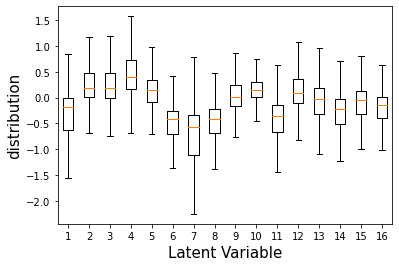

In [ ]:
plt.boxplot(data, showfliers=False);
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

In [ ]:
simulation = flow_net.decoder(flow_net.td.sample(10)).mean().numpy()

In [ ]:
np.shape(simulation)

(10, 45, 45, 6)

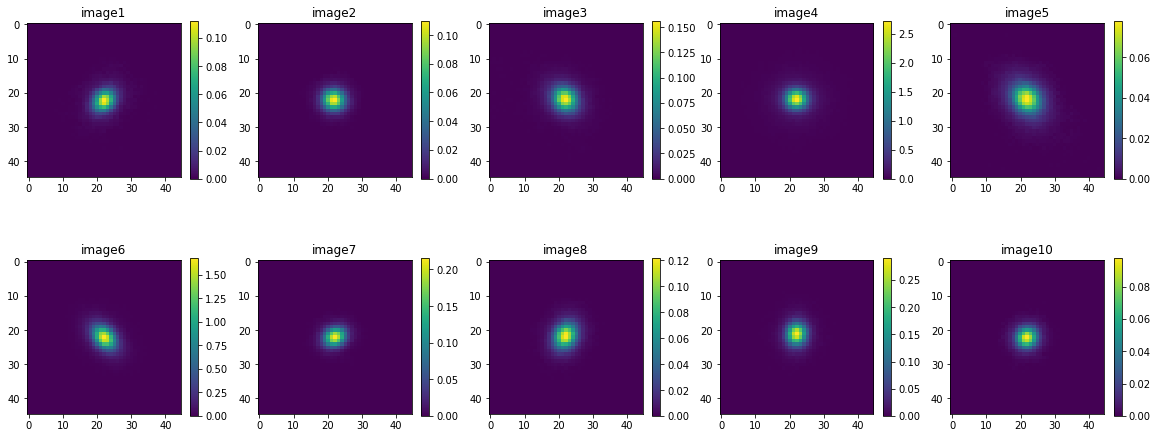

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))

for plot_row in range(2):
    for plot_col in range(5):

        im = axs[plot_row][plot_col].imshow(simulation[plot_row*5+plot_col, :, :, 2])
        fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))